In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
from tensorboardX import SummaryWriter
from attention_unet import AttU_Net
from attention_unet2 import resnet34_unet as ResNet_attUnet

In [2]:
# DATA_DIR = '/home/system/datasets/gallbladder1/crop'
# keshihua
DATA_DIR = '/home/system/datasets/gallbladder1/crop'
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_valid_dir = os.path.join(DATA_DIR, 'val/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask')

x_test_dir = os.path.join(DATA_DIR, 'vis/img')
y_test_dir = os.path.join(DATA_DIR, 'vis/mask')

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', 'gallbladder']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id).split('.')[0] + '_gt.png' for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], -1)                # png16   -1
#         print(self.class_values)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
#         mask[mask != 0] = 1
#         print(mask.max())
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
        
    def __len__(self):
        return len(self.ids)

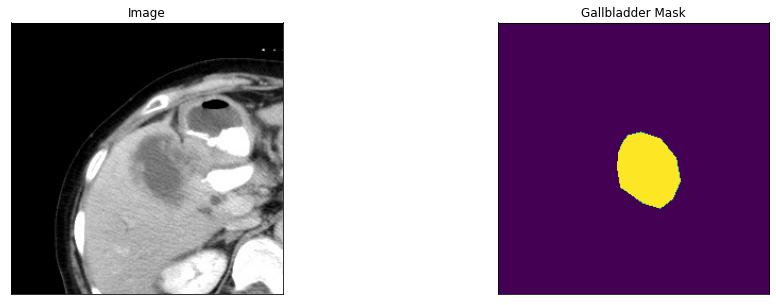

In [5]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['gallbladder'])

image, mask = dataset[0] # get some sample

visualize(
    image=image, 
    gallbladder_mask=mask.squeeze(),
)

In [6]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=320, width=320, always_apply=True),

#         albu.IAAAdditiveGaussianNoise(p=0.2),
#         albu.IAAPerspective(p=0.5),

#         albu.OneOf(
#             [
#                 albu.CLAHE(p=1),
# #                 albu.RandomBrightness(p=1),
# #                 albu.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#         albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [7]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['gallbladder']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
write = SummaryWriter('logs')
# create segmentation model with pretrained encoder
model = smp.Unet(
#     encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model = ResNet_attUnet(3,1)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [8]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
#     augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64
1.0


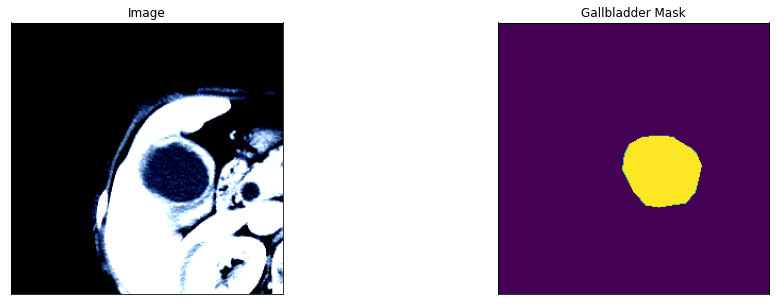

In [9]:
i = 0
for img, msk in train_loader:
    if i == 0:
        img = np.array(img)
        msk = np.array(msk)
        print(img.max())
        print(msk.max())
        visualize(
            image=img[0].transpose(1, 2, 0), 
            gallbladder_mask=msk[0].transpose(1, 2, 0).squeeze(),
        )
    else:
        break
    i+=1

In [10]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
EPOCHS = 50
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
]
# optimizer = torch.optim.SGD([ 
#     dict(params=model.parameters(), lr=0.01,momentum=0.8),
# ])
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.01),
])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30, eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8, 10, 15, 20], gamma=0.1)

In [11]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [12]:
# train model for 40 epochs

max_score = 0

for i in range(0, EPOCHS):
    lr = scheduler.get_last_lr()
    print('\nEpoch: {},lr:{}'.format(i, lr))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './models/attunet_best_model.pth')
        print('Model saved!')
    scheduler.step(i)   
    write.add_scalars('Train_val_loss', {'train_loss' + str(EPOCHS): train_logs['dice_loss']}, i + 1)
    write.add_scalars('Train_val_loss', {'val_loss' + str(EPOCHS): valid_logs['dice_loss']}, i + 1)
    write.add_scalars('IoU_score', {'train_IoU_score' + str(EPOCHS): train_logs['iou_score']}, i + 1)
    write.add_scalars('IoU_score', {'val_IoU_score' + str(EPOCHS): valid_logs['iou_score']}, i + 1)
    write.add_scalars('f_score', {'train_fscore' + str(EPOCHS): train_logs['fscore']}, i + 1)
    write.add_scalars('f_score', {'val_fscore' + str(EPOCHS): valid_logs['fscore']}, i + 1)
    write.add_scalars('accuracy', {'train_accuracy' + str(EPOCHS): train_logs['accuracy']}, i + 1)
    write.add_scalars('accuracy', {'val_accuracy' + str(EPOCHS): valid_logs['accuracy']}, i + 1)
    write.add_scalars('recall', {'train_recall' + str(EPOCHS): train_logs['recall']}, i + 1)
    write.add_scalars('recall', {'val_recall' + str(EPOCHS): valid_logs['recall']}, i + 1)
    write.add_scalars('precision', {'train_precision' + str(EPOCHS): train_logs['precision']}, i + 1)
    write.add_scalars('precision', {'val_precision' + str(EPOCHS): valid_logs['precision']}, i + 1)
    if i < 2:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')
        print('valid_logs',valid_logs)
        print('train_logs', train_logs)


Epoch: 0,lr:[0.01]
train:   1%|          | 2/386 [00:00<01:04,  5.94it/s, dice_loss - 0.8817, iou_score - 0.05696, fscore - 0.1071, accuracy - 0.0, recall - 0.6165, precision - 0.05957]

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


valid: 100%|██████████| 155/155 [00:06<00:00, 23.56it/s, dice_loss - 0.4165, iou_score - 0.42, fscore - 0.5835, accuracy - 0.0, recall - 0.4736, precision - 0.7964]  
Model saved!
valid_logs {'dice_loss': 0.4164584790506671, 'iou_score': 0.4199545865097354, 'fscore': 0.583450241050412, 'accuracy': 0.0, 'recall': 0.47359749559433245, 'precision': 0.7963695247327127}
train_logs {'dice_loss': 0.37918698911222165, 'iou_score': 0.46912929090463745, 'fscore': 0.6242566337432571, 'accuracy': 0.0, 'recall': 0.6905940329472632, 'precision': 0.6112524225362072}

Epoch: 1,lr:[0.01]
train:   0%|          | 1/386 [00:00<00:59,  6.52it/s, dice_loss - 0.2792, iou_score - 0.5636, fscore - 0.7209, accuracy - 0.0, recall - 0.7128, precision - 0.7291]

/home/system/anaconda3/envs/torch1.5/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


valid: 100%|██████████| 155/155 [00:06<00:00, 23.41it/s, dice_loss - 0.3224, iou_score - 0.5206, fscore - 0.6775, accuracy - 0.0, recall - 0.5753, precision - 0.8567]
Model saved!
valid_logs {'dice_loss': 0.32243845424344464, 'iou_score': 0.5205746464190946, 'fscore': 0.6775121554251639, 'accuracy': 0.0, 'recall': 0.575320162023267, 'precision': 0.8567196284571003}
train_logs {'dice_loss': 0.2461833949224935, 'iou_score': 0.6080926053727851, 'fscore': 0.7538536200251603, 'accuracy': 0.0, 'recall': 0.7660561775296456, 'precision': 0.7507838029317904}

Epoch: 2,lr:[0.009972636867364526]
valid: 100%|██████████| 155/155 [00:06<00:00, 22.76it/s, dice_loss - 0.237, iou_score - 0.6223, fscore - 0.763, accuracy - 0.0, recall - 0.7096, precision - 0.8393]  
Model saved!

Epoch: 3,lr:[0.009890847265665359]
valid: 100%|██████████| 155/155 [00:06<00:00, 23.35it/s, dice_loss - 0.3091, iou_score - 0.536, fscore - 0.6909, accuracy - 0.0, recall - 0.8102, precision - 0.6127] 

Epoch: 4,lr:[0.009755527

valid: 100%|██████████| 155/155 [00:06<00:00, 24.35it/s, dice_loss - 0.2, iou_score - 0.6746, fscore - 0.8, accuracy - 0.0, recall - 0.7378, precision - 0.8859]      

Epoch: 22,lr:[0.0020690126647990976]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.02it/s, dice_loss - 0.1875, iou_score - 0.692, fscore - 0.8125, accuracy - 0.0, recall - 0.763, precision - 0.8813]  

Epoch: 23,lr:[0.001662692621237505]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.12it/s, dice_loss - 0.1898, iou_score - 0.6879, fscore - 0.8102, accuracy - 0.0, recall - 0.7523, precision - 0.8901]

Epoch: 24,lr:[0.001292991596740417]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.37it/s, dice_loss - 0.1908, iou_score - 0.686, fscore - 0.8092, accuracy - 0.0, recall - 0.7477, precision - 0.8938] 

Epoch: 25,lr:[0.0009639601130971381]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.82it/s, dice_loss - 0.1912, iou_score - 0.6862, fscore - 0.8088, accuracy - 0.0, recall - 0.7506, precision - 0.8893]

Epoch: 26,lr:[

valid: 100%|██████████| 155/155 [00:06<00:00, 23.94it/s, dice_loss - 0.1907, iou_score - 0.6863, fscore - 0.8093, accuracy - 0.0, recall - 0.7496, precision - 0.8904]

Epoch: 44,lr:[0.00396648110436529]
valid: 100%|██████████| 155/155 [00:06<00:00, 23.60it/s, dice_loss - 0.1836, iou_score - 0.6952, fscore - 0.8164, accuracy - 0.0, recall - 0.7716, precision - 0.8765]

Epoch: 45,lr:[0.004482880325978067]
valid: 100%|██████████| 155/155 [00:06<00:00, 23.39it/s, dice_loss - 0.196, iou_score - 0.6788, fscore - 0.804, accuracy - 0.0, recall - 0.7311, precision - 0.9047]  

Epoch: 46,lr:[0.005004999999999999]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.08it/s, dice_loss - 0.1747, iou_score - 0.7077, fscore - 0.8253, accuracy - 0.0, recall - 0.8048, precision - 0.8559]
Model saved!

Epoch: 47,lr:[0.005527119674021927]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.46it/s, dice_loss - 0.1887, iou_score - 0.6875, fscore - 0.8113, accuracy - 0.0, recall - 0.7603, precision - 0.88]  

Epoc

In [13]:

Epoch: 0,lr:[0.01]
train: 100%|██████████| 386/386 [00:51<00:00,  7.55it/s, dice_loss - 0.3773, iou_score - 0.4712]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.58it/s, dice_loss - 0.3752, iou_score - 0.4605]
Model saved!
valid_logs {'dice_loss': 0.3751707503872536, 'iou_score': 0.46051916691564715}
train_logs {'dice_loss': 0.37733356399857326, 'iou_score': 0.4711621852273207}

Epoch: 1,lr:[0.01]
train:   0%|          | 1/386 [00:00<00:53,  7.22it/s, dice_loss - 0.2295, iou_score - 0.6267]

/home/system/anaconda3/envs/torch1.5/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)

train: 100%|██████████| 386/386 [00:50<00:00,  7.60it/s, dice_loss - 0.2729, iou_score - 0.5747]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.37it/s, dice_loss - 0.2591, iou_score - 0.5964]
Model saved!
valid_logs {'dice_loss': 0.2590934426553786, 'iou_score': 0.5963846343178902}
train_logs {'dice_loss': 0.2729355641906125, 'iou_score': 0.5746870414580707}

Epoch: 2,lr:[0.009972636867364526]
train: 100%|██████████| 386/386 [00:51<00:00,  7.47it/s, dice_loss - 0.2401, iou_score - 0.6164]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.17it/s, dice_loss - 0.2635, iou_score - 0.5899]

Epoch: 3,lr:[0.009890847265665359]
train: 100%|██████████| 386/386 [00:51<00:00,  7.51it/s, dice_loss - 0.2413, iou_score - 0.6149]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.16it/s, dice_loss - 0.4322, iou_score - 0.4034]

Epoch: 4,lr:[0.009755527298894293]
train: 100%|██████████| 386/386 [00:51<00:00,  7.46it/s, dice_loss - 0.2083, iou_score - 0.6581]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.09it/s, dice_loss - 0.3151, iou_score - 0.5264]

Epoch: 5,lr:[0.00956815956092479]
train: 100%|██████████| 386/386 [00:53<00:00,  7.24it/s, dice_loss - 0.1969, iou_score - 0.6734]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.79it/s, dice_loss - 0.2437, iou_score - 0.6145]
Model saved!

Epoch: 6,lr:[0.009330796891903272]
train: 100%|██████████| 386/386 [00:53<00:00,  7.24it/s, dice_loss - 0.1843, iou_score - 0.6913]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.41it/s, dice_loss - 0.2692, iou_score - 0.5817]

Epoch: 7,lr:[0.009046039886902862]
train: 100%|██████████| 386/386 [00:53<00:00,  7.25it/s, dice_loss - 0.1561, iou_score - 0.7318]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.92it/s, dice_loss - 0.2085, iou_score - 0.6601]
Model saved!

Epoch: 8,lr:[0.008717008403259584]
train: 100%|██████████| 386/386 [00:53<00:00,  7.27it/s, dice_loss - 0.1489, iou_score - 0.7426]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.17it/s, dice_loss - 0.2354, iou_score - 0.6252]

Epoch: 9,lr:[0.008347307378762497]
train: 100%|██████████| 386/386 [00:53<00:00,  7.25it/s, dice_loss - 0.1543, iou_score - 0.7354]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.74it/s, dice_loss - 0.2167, iou_score - 0.6502]

Epoch: 10,lr:[0.007940987335200904]
train: 100%|██████████| 386/386 [00:53<00:00,  7.24it/s, dice_loss - 0.1355, iou_score - 0.7627]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.70it/s, dice_loss - 0.2523, iou_score - 0.6054]

Epoch: 11,lr:[0.0075025000000000005]
train: 100%|██████████| 386/386 [00:53<00:00,  7.15it/s, dice_loss - 0.122, iou_score - 0.7836] 
valid: 100%|██████████| 155/155 [00:06<00:00, 24.75it/s, dice_loss - 0.2042, iou_score - 0.6673]
Model saved!

Epoch: 12,lr:[0.007036649532163623]
train: 100%|██████████| 386/386 [00:52<00:00,  7.30it/s, dice_loss - 0.1132, iou_score - 0.7974]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.69it/s, dice_loss - 0.2309, iou_score - 0.6327]

Epoch: 13,lr:[0.006548539886902863]
train: 100%|██████████| 386/386 [00:52<00:00,  7.31it/s, dice_loss - 0.1139, iou_score - 0.7966]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.69it/s, dice_loss - 0.1793, iou_score - 0.7005]
Model saved!

Epoch: 14,lr:[0.006043518895634707]
train: 100%|██████████| 386/386 [00:53<00:00,  7.26it/s, dice_loss - 0.1038, iou_score - 0.8125]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.78it/s, dice_loss - 0.1765, iou_score - 0.7045]
Model saved!

Epoch: 15,lr:[0.005527119674021929]
train: 100%|██████████| 386/386 [00:53<00:00,  7.26it/s, dice_loss - 0.1011, iou_score - 0.817]  
valid: 100%|██████████| 155/155 [00:06<00:00, 25.02it/s, dice_loss - 0.2053, iou_score - 0.6641]

Epoch: 16,lr:[0.005005000000000001]
train: 100%|██████████| 386/386 [00:53<00:00,  7.17it/s, dice_loss - 0.09629, iou_score - 0.8249]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.41it/s, dice_loss - 0.1811, iou_score - 0.6973]

Epoch: 17,lr:[0.004482880325978072]
train: 100%|██████████| 386/386 [00:53<00:00,  7.23it/s, dice_loss - 0.09549, iou_score - 0.8263]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.53it/s, dice_loss - 0.2169, iou_score - 0.6518]

Epoch: 18,lr:[0.003966481104365292]
train: 100%|██████████| 386/386 [00:53<00:00,  7.24it/s, dice_loss - 0.09419, iou_score - 0.8285]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.57it/s, dice_loss - 0.195, iou_score - 0.6786] 

Epoch: 19,lr:[0.0034614601130971384]
train: 100%|██████████| 386/386 [00:53<00:00,  7.24it/s, dice_loss - 0.08985, iou_score - 0.8357]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.78it/s, dice_loss - 0.182, iou_score - 0.6966] 

Epoch: 20,lr:[0.002973350467836379]
train: 100%|██████████| 386/386 [00:53<00:00,  7.18it/s, dice_loss - 0.08545, iou_score - 0.843] 
valid: 100%|██████████| 155/155 [00:06<00:00, 24.60it/s, dice_loss - 0.1817, iou_score - 0.6973]

Epoch: 21,lr:[0.0025075000000000015]
train: 100%|██████████| 386/386 [00:53<00:00,  7.21it/s, dice_loss - 0.08352, iou_score - 0.8462]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.67it/s, dice_loss - 0.2104, iou_score - 0.6576]

Epoch: 22,lr:[0.0020690126647990976]
train: 100%|██████████| 386/386 [00:53<00:00,  7.27it/s, dice_loss - 0.08127, iou_score - 0.85]  
valid: 100%|██████████| 155/155 [00:06<00:00, 24.95it/s, dice_loss - 0.1747, iou_score - 0.7065]
Model saved!

Epoch: 23,lr:[0.001662692621237505]
train: 100%|██████████| 386/386 [00:53<00:00,  7.22it/s, dice_loss - 0.07885, iou_score - 0.8541]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.07it/s, dice_loss - 0.1782, iou_score - 0.7015]

Epoch: 24,lr:[0.001292991596740417]
train: 100%|██████████| 386/386 [00:53<00:00,  7.26it/s, dice_loss - 0.07719, iou_score - 0.857] 
valid: 100%|██████████| 155/155 [00:06<00:00, 24.74it/s, dice_loss - 0.1772, iou_score - 0.7029]

Epoch: 25,lr:[0.0009639601130971381]
train: 100%|██████████| 386/386 [00:53<00:00,  7.25it/s, dice_loss - 0.07592, iou_score - 0.8592]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.82it/s, dice_loss - 0.1843, iou_score - 0.6929]

Epoch: 26,lr:[0.0006792031080967287]
train: 100%|██████████| 386/386 [00:53<00:00,  7.27it/s, dice_loss - 0.07403, iou_score - 0.8624]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.59it/s, dice_loss - 0.1791, iou_score - 0.7004]

Epoch: 27,lr:[0.0004418404390752082]
train: 100%|██████████| 386/386 [00:53<00:00,  7.25it/s, dice_loss - 0.07329, iou_score - 0.8637]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.80it/s, dice_loss - 0.1808, iou_score - 0.6978]

Epoch: 28,lr:[0.00025447270110570816]
train: 100%|██████████| 386/386 [00:53<00:00,  7.22it/s, dice_loss - 0.07238, iou_score - 0.8653]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.46it/s, dice_loss - 0.1811, iou_score - 0.6974]

Epoch: 29,lr:[0.0001191527343346406]
train: 100%|██████████| 386/386 [00:54<00:00,  7.07it/s, dice_loss - 0.07198, iou_score - 0.866] 
valid: 100%|██████████| 155/155 [00:06<00:00, 24.43it/s, dice_loss - 0.1805, iou_score - 0.6982]

Epoch: 30,lr:[3.736313263547436e-05]
train: 100%|██████████| 386/386 [00:53<00:00,  7.22it/s, dice_loss - 0.0714, iou_score - 0.867]  
valid: 100%|██████████| 155/155 [00:06<00:00, 24.98it/s, dice_loss - 0.1808, iou_score - 0.6977]

Epoch: 31,lr:[1e-05]
train: 100%|██████████| 386/386 [00:53<00:00,  7.18it/s, dice_loss - 0.07173, iou_score - 0.8665]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.82it/s, dice_loss - 0.1815, iou_score - 0.6968]

Epoch: 32,lr:[3.736313263547436e-05]
train: 100%|██████████| 386/386 [00:54<00:00,  7.09it/s, dice_loss - 0.07156, iou_score - 0.8667]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.21it/s, dice_loss - 0.1805, iou_score - 0.6982]

Epoch: 33,lr:[0.0001191527343346406]
train: 100%|██████████| 386/386 [00:53<00:00,  7.19it/s, dice_loss - 0.07162, iou_score - 0.8666]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.86it/s, dice_loss - 0.1857, iou_score - 0.691] 

Epoch: 34,lr:[0.0002544727011057076]
train: 100%|██████████| 386/386 [00:53<00:00,  7.23it/s, dice_loss - 0.0715, iou_score - 0.8668] 
valid: 100%|██████████| 155/155 [00:06<00:00, 24.75it/s, dice_loss - 0.1849, iou_score - 0.692] 

Epoch: 35,lr:[0.00044184043907520874]

train: 100%|██████████| 386/386 [00:51<00:00,  7.50it/s, dice_loss - 0.07176, iou_score - 0.8664]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.26it/s, dice_loss - 0.1826, iou_score - 0.6955]

Epoch: 36,lr:[0.0006792031080967282]
train: 100%|██████████| 386/386 [00:51<00:00,  7.49it/s, dice_loss - 0.07174, iou_score - 0.8664]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.65it/s, dice_loss - 0.1793, iou_score - 0.7]   

Epoch: 37,lr:[0.000963960113097137]
train: 100%|██████████| 386/386 [00:51<00:00,  7.49it/s, dice_loss - 0.07196, iou_score - 0.866] 
valid: 100%|██████████| 155/155 [00:06<00:00, 25.49it/s, dice_loss - 0.1683, iou_score - 0.7157]
Model saved!

Epoch: 38,lr:[0.0012929915967404158]
train: 100%|██████████| 386/386 [00:51<00:00,  7.55it/s, dice_loss - 0.07247, iou_score - 0.8651]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.72it/s, dice_loss - 0.1814, iou_score - 0.697] 

Epoch: 39,lr:[0.001662692621237502]
train: 100%|██████████| 386/386 [00:50<00:00,  7.57it/s, dice_loss - 0.07316, iou_score - 0.864] 
valid: 100%|██████████| 155/155 [00:06<00:00, 23.90it/s, dice_loss - 0.1825, iou_score - 0.6953]

Epoch: 40,lr:[0.0020690126647990963]
train: 100%|██████████| 386/386 [00:51<00:00,  7.51it/s, dice_loss - 0.07506, iou_score - 0.8607]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.32it/s, dice_loss - 0.1906, iou_score - 0.6845]

Epoch: 41,lr:[0.002507499999999998]
train: 100%|██████████| 386/386 [00:54<00:00,  7.15it/s, dice_loss - 0.07378, iou_score - 0.8629]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.76it/s, dice_loss - 0.194, iou_score - 0.6806] 

Epoch: 42,lr:[0.002973350467836375]
train: 100%|██████████| 386/386 [00:53<00:00,  7.28it/s, dice_loss - 0.07465, iou_score - 0.8614]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.11it/s, dice_loss - 0.1747, iou_score - 0.7063]

Epoch: 43,lr:[0.003461460113097137]
train: 100%|██████████| 386/386 [00:52<00:00,  7.28it/s, dice_loss - 0.07612, iou_score - 0.8588]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.17it/s, dice_loss - 0.1825, iou_score - 0.6959]

Epoch: 44,lr:[0.00396648110436529]
train: 100%|██████████| 386/386 [00:52<00:00,  7.31it/s, dice_loss - 0.07772, iou_score - 0.8561]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.14it/s, dice_loss - 0.1782, iou_score - 0.7017]

Epoch: 45,lr:[0.004482880325978067]
train: 100%|██████████| 386/386 [00:53<00:00,  7.24it/s, dice_loss - 0.07697, iou_score - 0.8574]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.60it/s, dice_loss - 0.2032, iou_score - 0.6667]

Epoch: 46,lr:[0.005004999999999999]
train: 100%|██████████| 386/386 [00:53<00:00,  7.26it/s, dice_loss - 0.08234, iou_score - 0.8483]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.40it/s, dice_loss - 0.1965, iou_score - 0.6774]

Epoch: 47,lr:[0.005527119674021927]
train: 100%|██████████| 386/386 [00:53<00:00,  7.26it/s, dice_loss - 0.08764, iou_score - 0.8393]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.95it/s, dice_loss - 0.1986, iou_score - 0.6767]

Epoch: 48,lr:[0.006043518895634708]
train: 100%|██████████| 386/386 [00:53<00:00,  7.27it/s, dice_loss - 0.08112, iou_score - 0.8504]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.82it/s, dice_loss - 0.1664, iou_score - 0.7187]
Model saved!

Epoch: 49,lr:[0.006548539886902862]
train: 100%|██████████| 386/386 [00:53<00:00,  7.28it/s, dice_loss - 0.08297, iou_score - 0.8473]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.65it/s, dice_loss - 0.1957, iou_score - 0.6777]

# load best saved checkpoint

best_model = torch.load('./models/resattunet_best_model_0.71.pth')

SyntaxError: invalid syntax (<ipython-input-13-29a3da58a393>, line 1)

In [ ]:
# load best saved checkpoint
best_model = torch.load('./models/attunet_best_model_crop.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
model.eval()
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    gt_mask[gt_mask != 0] = 1 
    gt_mask[gt_mask == 0] = 0 
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pr_mask = best_model.predict(x_tensor)
    with torch.no_grad():
        
        pr_mask = best_model(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask[pr_mask != 0] = 1  
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [3]:
a = 0.72
2*a/(1+a)

0.8372093023255813